# Pixels to Tabular Data
## Agricultural Statistical Analysis Use Case

Talk about pixels and tabular data.

The use case addressed in this tutorial is:  

* As an agriculture customer, I'd like to create an imagery pipeline that provides for trialing different fungicides by ordering Planet imagery within a single field (AOI), cutting the imagery into multiple field blocks, filtering based on cloud coverage within the blocks, and comparing values across blocks in two ways. First, comparison is performed by extracting median, mean, variance NDVI values for each day (using random point sampling) in each block. Second, comparison is performed by random point selection in each block.


## Introduction

Two things are interesting about this use case. First, we are gridding the AOI into blocks. Second, we are performing some calculations with the output to compare results across different blocks in the field. 


## Implementation

For this use case, the area of interest is specified (the field) but the time range is not. For time-series analysis the daily coverage of PS satellites is ideal. Because we are only looking at a field, we want to clip the images to the field area of interest to avoid unnecessary pixel wrangling. Also, we don't need all the bands, we are only interested in NDVI. We can use the Orders API to help us clip the images and calculate NDVI. Finally, we will need to implement a bit of functionality to filter to images that have no unusable pixels within the area of interest and for the comparisons across the field blocks.

To summarize, these are the major steps:
1. [Part 1: Setup](#Part-1:-Setup)
1. [Part 2: Get Field NDVI](#Part-2:-Get-Field-NDVI)
1. [Part 3: Sample Field Blocks](#Part-3:-Sample-Field-Blocks)

### Part 1: Setup

In this section, we set up the notebook and define the field and field block geometries.

#### Import Dependencies

In [78]:
import datetime
import json
import os
from pathlib import Path
from pprint import pprint
import shutil
import time
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from planet import Auth, reporting
from planet import Session, DataClient, OrdersClient
import pyproj
import rasterio
from rasterio import plot
import requests
from rasterio.mask import raster_geometry_mask
from shapely.geometry import shape, MultiPolygon
from shapely.ops import transform

#### Get Field and Sample Blocks AOIs

In [2]:
def load_geojson(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [3]:
# this feature comes from within the sacramento_crops aoi
# it is the first feature in 'ground-truth-test.geojson', which
# was prepared in crop-classification/datasets-prepare.ipynb
field_filename = os.path.join('pre-data', 'field.geojson')
field = load_geojson(field_filename)
pprint(field)

{'geometry': {'coordinates': [[[-121.26311573121106, 38.28911976564886],
                               [-121.26309824204209, 38.289263573446426],
                               [-121.26340336500914, 38.28927552343227],
                               [-121.26341580611164, 38.28958419507872],
                               [-121.26335908094813, 38.290060214043095],
                               [-121.2633553819847, 38.29021303818384],
                               [-121.26200888330872, 38.2901989348931],
                               [-121.26202642045222, 38.28924931063856],
                               [-121.26202881277432, 38.28911976564886],
                               [-121.26311573121106, 38.28911976564886]]],
              'type': 'Polygon'},
 'id': '10906',
 'properties': {'ACRES': 5.382,
                'AREA': 21779.33318,
                'BL_X': 651939,
                'BL_Y': 4239347,
                'CLASS1': 'G',
                'CLASS2': '**',
                'CLAS

5.382 acres


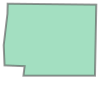

In [4]:
# visualize field and determine size in acres

print('{} acres'.format(field['properties']['ACRES']))
field_aoi = field['geometry']
shape(field_aoi)

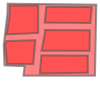

In [5]:
# visualize field and sample blocks
# these blocks were drawn by hand randomly for this demo
# they don't actually represent test field blocks

blocks = load_geojson(os.path.join('pre-data', 'blocks.geojson'))
block_aois = [b['geometry'] for b in blocks]
MultiPolygon([shape(a) for a in [field_aoi] + block_aois])

### Part 2: Get Field NDVI

In this section, we use the Data and Orders APIs to find images that overlap the field AOI in the specified time period and then to download the NDVI values of pixels within the field for all of the images. Once the images are downloaded, we use the UDM2 asset to filter to images that have no unusable pixels within the AOI. Finally, we get to check out what the NDVI of the field looks like!

#### Step 1: Search Data API

The goal of this step is to get the scene ids that meet the search criteria for this use case.

In [10]:
# if your Planet API Key is not set as an environment variable, you can paste it below
API_KEY = os.environ.get('PL_API_KEY', 'PASTE_API_KEY_HERE')

# Setup Planet Data API base URL
URL = "https://api.planet.com/data/v1"

# Setup the session
session = requests.Session()

# Authenticate
session.auth = (API_KEY, "")

In [12]:
# create an API Request from the search specifications

item_type = ['PSScene']

geom_filter = {
   "type":"GeometryFilter",
   "field_name":"geometry",
   "config":field_aoi
}

date_range_filter = {
"type":"DateRangeFilter",
"field_name":"acquired",
"config":{
  "gt":"2019-04-01T00:00:00Z", 
   "lt": "2019-05-01T00:00:00Z"}
}

combined_filter = {
"type":"AndFilter",
"config":[
    geom_filter,
    date_range_filter]
}

async with Session() as sess:
    cl = DataClient(sess)
    request = await cl.create_search(name='fsa_search',search_filter=combined_filter, item_types=item_type)

In [15]:
print(request)

{'__daily_email_enabled': False, '_links': {'_self': 'https://api.planet.com/data/v1/searches/c912aa02a91b4fe3b733b3d8c28c315d', 'results': 'https://api.planet.com/data/v1/searches/c912aa02a91b4fe3b733b3d8c28c315d/results'}, 'created': '2022-09-15T21:07:37.901990Z', 'filter': {'config': [{'config': {'coordinates': [[[-121.26311573121106, 38.28911976564886], [-121.26309824204209, 38.289263573446426], [-121.26340336500914, 38.28927552343227], [-121.26341580611164, 38.28958419507872], [-121.26335908094813, 38.290060214043095], [-121.2633553819847, 38.29021303818384], [-121.26200888330872, 38.2901989348931], [-121.26202642045222, 38.28924931063856], [-121.26202881277432, 38.28911976564886], [-121.26311573121106, 38.28911976564886]]], 'type': 'Polygon'}, 'field_name': 'geometry', 'type': 'GeometryFilter'}, {'config': {'gt': '2019-04-01T00:00:00Z', 'lt': '2019-05-01T00:00:00Z'}, 'field_name': 'acquired', 'type': 'DateRangeFilter'}], 'type': 'AndFilter'}, 'id': 'c912aa02a91b4fe3b733b3d8c28c31

In [16]:
# Search the Data API
async with Session() as sess:
    cl = DataClient(sess)
    items = await cl.run_search(search_id=request['id'])
    item_list = [i async for i in items]

In [17]:
print('{} images match the search criteria.'.format(len(item_list)))

34 images match the search criteria.


In [638]:
# uncomment to see what an item looks like
# pprint(item_list[0])

Now that we have found the images that match the search criteria, let's make sure all of the images fully contain the field AOI (we don't want to just get half of the field) and then let's see what the image footprint and the AOI look like together.

In [18]:
footprints = [shape(i['geometry']) for i in item_list]

In [19]:
# make sure all footprints contain the field aoi (that is, no partial overlaps)
for f in footprints:
    assert f.contains(shape(field_aoi))

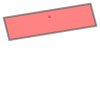

In [20]:
# visualize aoi and footprint
MultiPolygon([shape(field_aoi), footprints[0]])

Whoa look! That AOI is tiny relative to the image footprint. We don't want to wrangle all those pixels outside of the AOI. We definately want to clip the imagery footprints to the AOI.

#### Step 2: Submit Order

Now that we have the scene ids, we can create the order. The output of this step is a single zip file that contains all of the scenes that meet our criteria.

The tools we want to apply are: clip imagery to AOI and convert imagery to NDVI. 

##### Step 2.1: Define Toolchain Tools

In [30]:
# define the clip tool
clip = {
    "clip": {
        "aoi": field_aoi
    }
}

In [31]:
# Define bandmath tool: NDVI
ndvi_tool = {'bandmath': {
    "pixel_type": "32R",
    "b1": "(b4 - b3) / (b4+b3)"
}}

In [21]:
def get_tools(aoi_geom):
    # clip to AOI
    clip_tool = {'clip': {'aoi': aoi_geom}}

    # convert to NDVI
    ndvi_tool = {'bandmath': {
        "pixel_type": "32R",
        "b1": "(b4 - b3) / (b4+b3)"
    }}

    tools = [clip_tool, ndvi_tool]
    return tools

##### Step 2.2: Build Order Requests

In [35]:
# specify the PSScene 4-Band surface reflectance product
# make sure to get the *_udm2 bundle so you get the udm2 product
# note: capitalization really matters in item_type when using planet client orders api
item_type = 'PSScene'
bundle = 'analytic_sr_udm2'
ids = [i['id'] for i in item_list]
name = 'pixels_to_tabular'

orders_request = {
    'name': name,
    'products': [{
        'item_ids': ids,
        'item_type': item_type,
        'product_bundle': bundle
    }],
    'tools': [clip, ndvi_tool],
    'delivery': {
        'single_archive': True,
        'archive_filename':'{{name}}_{{order_id}}.zip',
        'archive_type':'zip'
    },
        'notifications': {
                   'email': False
    },
}

##### Step 2.3: Submit Order

In [ ]:
async with Session() as sess:
    cl = OrdersClient(sess)
    order = await cl.create_order(orders_request)

In [ ]:
order

#### Step 3: Poll for Success & Download Orders

Before we can download the orders, they have to be prepared on the server. Then, we can use the Python SDK to download our order.

In [62]:
# "async def" to create the async coroutine

async with Session() as sess:
    cl = OrdersClient(sess)

    # Use "reporting" to manage polling for order status
    with reporting.StateBar(state='creating') as bar:
        # Grab the order ID
        bar.update(state='created', order_id=order['id'])

        # poll...poll...poll...
        await cl.wait(order['id'], callback=bar.update_state)

    # if we get here that means the order completed. Yay! Download the files.
    filenames = await cl.download_order(order['id'])


00:00 - order b866959c-8332-4d07-8ea8-2f53b40613a0 - state: success


In [63]:
filenames

[PosixPath('b866959c-8332-4d07-8ea8-2f53b40613a0/pixels_to_tabular_b866959c-8332-4d07-8ea8-2f53b40613a0.zip'),
 PosixPath('b866959c-8332-4d07-8ea8-2f53b40613a0/manifest.json')]

#### Step 4: Unzip Order

In this section, we will unzip the order into a directory named after the downloaded zip file.

In [73]:
def unzip(filenames, overwrite=True):
    for filename in filenames:
        if Path(filename).name.endswith('.zip'):
            location = Path(filename)
            zipdir = location.parent / location.stem

            if os.path.isdir(zipdir):
                if overwrite:
                    print('{} exists. overwriting.'.format(zipdir))
                    shutil.rmtree(zipdir)
                else:
                    raise Exception('{} already exists'.format(zipdir))

            with ZipFile(location) as myzip:
                myzip.extractall(zipdir)
        return zipdir

zipdir = unzip(filenames)
zipdir

b866959c-8332-4d07-8ea8-2f53b40613a0/pixels_to_tabular_b866959c-8332-4d07-8ea8-2f53b40613a0 exists. overwriting.


PosixPath('b866959c-8332-4d07-8ea8-2f53b40613a0/pixels_to_tabular_b866959c-8332-4d07-8ea8-2f53b40613a0')

In [74]:
def get_unzipped_files(zipdir):
    filedir = zipdir / 'files'
    filenames = os.listdir(filedir)
    return [filedir / f for f in filenames]

file_paths = get_unzipped_files(zipdir)
file_paths[0]

PosixPath('b866959c-8332-4d07-8ea8-2f53b40613a0/pixels_to_tabular_b866959c-8332-4d07-8ea8-2f53b40613a0/files/20190426_173530_1049_metadata.json')

#### Step 5: Filter by Cloudiness

In this section, we will filter images that have any clouds within the AOI. We use the Unusable Data Mask (UDM2) to determine cloud pixels.

In [75]:
udm2_files = [f for f in file_paths if 'udm2' in str(f)]

In [90]:
# we want to find pixels that are inside the footprint but cloudy
# the easiest way to do this is is the udm values (band 8)
# https://developers.planet.com/docs/data/udm-2/
# the UDM values are given in 
# https://assets.planet.com/docs/Combined-Imagery-Product-Spec-Dec-2018.pdf
# Bit 0: blackfill (footprint)
# Bit 1: cloud covered
def read_udm(udm2_filename):
    with rasterio.open(udm2_filename) as img:
        # band 8 is the udm band
        return img.read(8)

In [79]:
def get_cloudy_percent(udm_band):
    blackfill = udm_band == int('1', 2)
    footprint_count = udm_band.size - np.count_nonzero(blackfill)
    cloudy = udm_band.size - udm_band == int('10', 2)
    cloudy_count = np.count_nonzero(cloudy)
    return (cloudy_count / footprint_count)

get_cloudy_percent(read_udm(udm2_files[0]))

0.0

In [80]:
clear_udm2_files = [f for f in udm2_files
                    if get_cloudy_percent(read_udm(f)) < 0.00001]
print(len(clear_udm2_files))

33


In [81]:
def get_id(udm2_filename):
    return udm2_filename.name.split('_3B')[0]
    
clear_ids = [get_id(f) for f in clear_udm2_files]
clear_ids[0]

'20190403_182837_1002'

#### Step 6: Get Clear Images


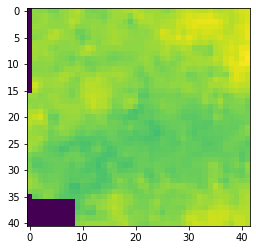

<AxesSubplot:>

In [82]:
def get_img_path(img_id, file_paths):
    filename = '{}_3B_AnalyticMS_SR_clip_bandmath.tif'.format(img_id)
    return next(f for f in file_paths if f.name == filename)

def read_ndvi(img_filename):
    with rasterio.open(img_filename) as img:
        # ndvi is a single-band image
        band = img.read(1)
    return band

plot.show(read_ndvi(get_img_path(clear_ids[0], file_paths)))

The field AOI isn't an exact square so there are some blank pixels. Let's mask those out. We can use the UDM for that.

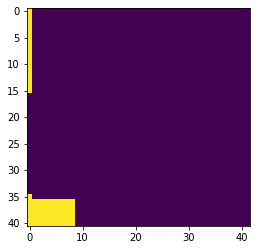

<AxesSubplot:>

In [83]:
def get_udm2_path(img_id, file_paths):
    filename = '{}_3B_udm2_clip.tif'.format(img_id)
    return next(f for f in file_paths if f.name == filename)
    
def read_blackfill(udm2_filename):
    with rasterio.open(udm2_filename) as img:
        # the last band is the udm band
        udm_band = img.read(8)
    blackfill = udm_band == int('1', 2)
    return blackfill

plot.show(read_blackfill(get_udm2_path(clear_ids[0], file_paths)))

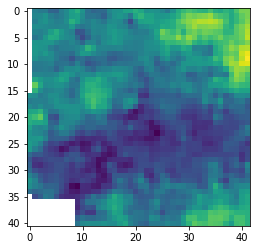

<AxesSubplot:>

In [84]:
# there is an issue where some udms aren't the same size as the images
# to deal with this just cut off any trailing rows/columns
# this isn't ideal as it can result in up to one pixel shift in x or y direction
def crop(img, shape):
    return img[:shape[0], :shape[1]]

def read_masked_ndvi(img_filename, udm2_filename):
    ndvi = read_ndvi(img_filename)
    blackfill = read_blackfill(udm2_filename)
        
    # crop image and mask to same size
    img_shape = min(ndvi.shape, blackfill.shape)
    ndvi = np.ma.array(crop(ndvi, img_shape), mask=crop(blackfill, img_shape))
    return ndvi

plot.show(read_masked_ndvi(get_img_path(clear_ids[0], file_paths),
                           get_udm2_path(clear_ids[0], file_paths)))

That looks better! We now have the NDVI values for the pixels within the field AOI.

Now, lets make that a little easier to generate.

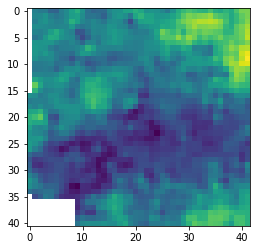

<AxesSubplot:>

In [85]:
def read_masked_ndvi_by_id(iid, file_paths):
    return read_masked_ndvi(get_img_path(iid, file_paths), get_udm2_path(iid, file_paths))

plot.show(read_masked_ndvi_by_id(clear_ids[0], file_paths))

In the images above, we are just using the default visualization for the imagery.

But this is NDVI imagery. Values are given between -1 and 1. Let's see how this looks if we use visualization specivic to NDVI.

In [86]:
# we demonstrated visualization in the best practices tutorial
# here, we save space by just importing the functionality
from visual import show_ndvi

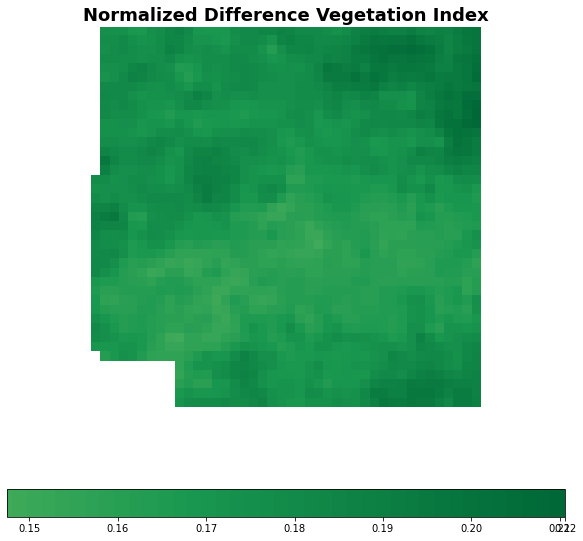

In [87]:
# and here's what it looks like when we visualize as ndvi
# (data range -1 to 1). it actually looks worse becaue the
# pixel value range is so small
show_ndvi(read_masked_ndvi_by_id(clear_ids[0], file_paths))

Well, the contrast has certainly gone down. This is because the NDVI values within the field are pretty uniform. That's what we would expect for a uniform field! So it is actually good news. The NDVI values are pretty low, ranging from 0.16 to just above 0.22. The time range used for this search is basically the month of April. This is pretty early in the growth season and so likely the plants are still tiny seedlings. So even the low NDVI value makes sense here.

### Part 3: Sample Field Blocks

Ok, here is where we convert pixels to tabular data. We do this for one image then we expand to doing this for all images in the time series.

In this section, we want to sample the pixel values within each field block and put the values into a table. For this, we first need to identify the field block pixels. Next, we calculate the median, mean, variance, and random point value for each field block. We put those into a table. And at the end we visualize the results.

#### Step 1: Get Field Block Pixels

In this step, we find the pixel values that are associated with each field block. To get the field block pixels, we have to project the block geometries into the image coordinates. Then we create masks that just pull the field block pixels from the aoi.

In [106]:
def block_aoi_masks(block_aois, ref_img_path):
    
    # find the coordinate reference system of the image
    with rasterio.open(ref_img_path) as src:
        dst_crs = src.crs
        
        # geojson features (the field block geometries)
        # are always given in WGS84
        # project these to the image coordinates
        wgs84 = pyproj.CRS('EPSG:4326')

        project = pyproj.Transformer.from_crs(wgs84, dst_crs, always_xy=True).transform
        proj_block_aois = [transform(project, shape(b)) for b in block_aois]

        masks = [raster_geometry_mask(src, [b], crop=False)[0]
                 for b in proj_block_aois]
    return masks

ref_img_path = get_img_path(clear_ids[0], file_paths)
block_masks = block_aoi_masks(block_aois, ref_img_path)

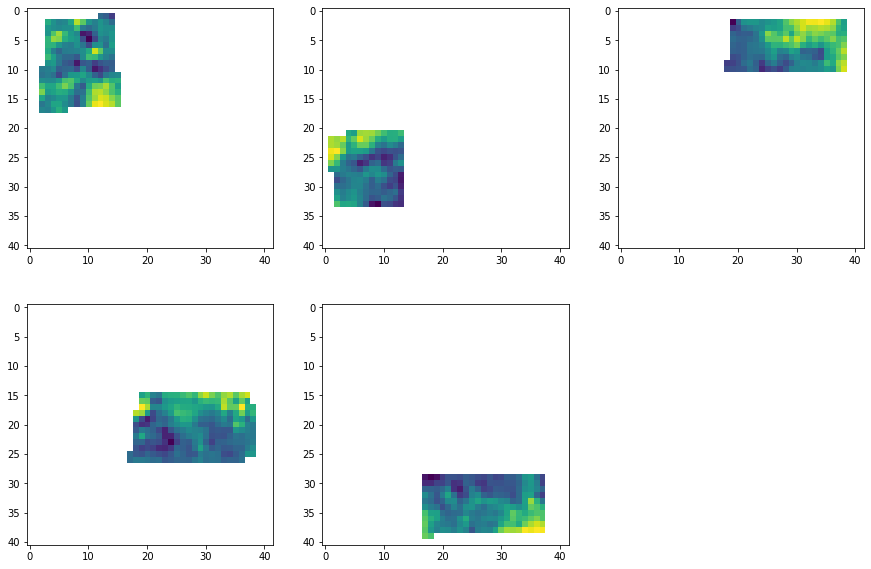

In [107]:
ndvi = read_masked_ndvi_by_id(clear_ids[0], file_paths)

fig, ax = plt.subplots(2,3, figsize=(15,10))
axf = ax.flatten()
fig.delaxes(axf[-1])
for i, mask in enumerate(block_masks):
    ndvi.mask = mask
    plot.show(ndvi, ax=axf[i])

#### Step 2: Random Sampling

Summary statistics such as mean, mode, and variance will be easy to calculate with the numpy python package. We need to do a little work to get random sampling, however.

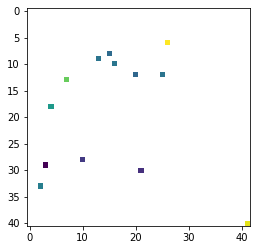

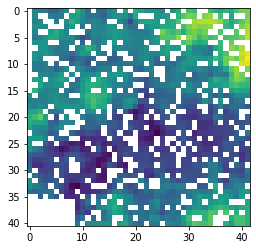

<AxesSubplot:>

In [110]:
np.random.seed(0) # 0 - make random sampling repeatable, no arg - nonrepeatable

def random_mask_sample(mask, count):
    # get shape of unmasked pixels
    unmasked = mask == False
    unmasked_shape = mask[unmasked].shape
    
    # uniformly sample pixel indices
    num_unmasked = unmasked_shape[0]
    idx = np.random.choice(num_unmasked, count, replace=False)
    
    # assign uniformly sampled indices to False (unmasked)
    random_mask = np.ones(unmasked_shape, dtype=bool)
    random_mask[idx] = False
    
    # reshape back to image shape and account for image mask
    random_sample_mask = np.ones(mask.shape, dtype=bool)
    random_sample_mask[unmasked] = random_mask
    return random_sample_mask


# lets just check out how our random sampling performs
ndvi = read_masked_ndvi_by_id(clear_ids[0], file_paths)
ndvi.mask = random_mask_sample(ndvi.mask, 13)
plot.show(ndvi)

ndvi = read_masked_ndvi_by_id(clear_ids[0], file_paths)
ndvi.mask = random_mask_sample(ndvi.mask, 1300)
plot.show(ndvi)

Ok, great! The first image shows what would result from sampling 13 pixels. The second image is for nearly all the pixels and demonstrates that the mask is taken into account with sampling.

Now lets get down to calculating the summary statistics and placing them in a table entry.

#### Step 3: Prepare Table of Summary Statistics

Now that we have all the tools we need, we are ready to calculate summary statistics for each field block and put them into a table. We will calculate the median, mean, variance, and single random point value for each field block.

In [111]:
def get_stats(ndvi, masks):
    def _get_stats(mask, block_number):
        block = np.ma.array(ndvi, mask=mask)

        mean = np.ma.mean(block)
        median = np.ma.median(block)
        var = np.ma.var(block)
        
        random_mask = random_mask_sample(block.mask, 1)
        random_val = np.ma.mean(np.ma.array(block, mask=random_mask))
        
        return {'block': block_number,
                'mean': mean,
                'median': median,
                'variance': var,
                'random': random_val}
    
    data = [_get_stats(m, i) for i, m in enumerate(masks)]
    df = pd.DataFrame(data)
    return df
        

ndvi = read_masked_ndvi_by_id(clear_ids[0], file_paths)
get_stats(ndvi, block_masks)       

,block,mean,median,variance,random
0,0,0.176674,0.176204,0.000030,0.168622
1,1,0.162676,0.161814,0.000054,0.157794
2,2,0.184550,0.184010,0.000089,0.175415
3,3,0.162456,0.161059,0.000040,0.160133
4,4,0.170481,0.169622,0.000067,0.167139


Okay! We have statistics for each block in a table. Yay! Okay, now lets move on to running this across a time series.

#### Step 4: Perform Time Series Analysis


In [112]:
def get_stats_by_id(iid, block_masks, file_paths):
    ndvi = read_masked_ndvi_by_id(iid, file_paths)
    ndvi_stats = get_stats(ndvi, block_masks)
    acquired = get_acquired(iid)
    ndvi_stats['acquired'] = [acquired]*len(block_masks)
    return ndvi_stats

def get_acquired(iid):
    metadata_path = get_metadata(iid, file_paths)
    
    with open(metadata_path) as src:
        md = json.load(src)
    return md['properties']['acquired']
    

def get_metadata(img_id, file_paths):
    filename = '{}_metadata.json'.format(img_id)
    return next(f for f in file_paths if f.name == filename)

get_stats_by_id(clear_ids[0], block_masks, file_paths)

,block,mean,median,variance,random,acquired
0,0,0.176674,0.176204,0.000030,0.181682,2019-04-03T18:28:37.143803Z
1,1,0.162676,0.161814,0.000054,0.158862,2019-04-03T18:28:37.143803Z
2,2,0.184550,0.184010,0.000089,0.193439,2019-04-03T18:28:37.143803Z
3,3,0.162456,0.161059,0.000040,0.171806,2019-04-03T18:28:37.143803Z
4,4,0.170481,0.169622,0.000067,0.172035,2019-04-03T18:28:37.143803Z


In [113]:
dfs = [get_stats_by_id(i, block_masks, file_paths) for i in clear_ids]
all_stats = pd.concat(dfs)

In [114]:
all_stats

,block,mean,median,variance,random,acquired
0,0,0.176674,0.176204,0.000030,0.177962,2019-04-03T18:28:37.143803Z
1,1,0.162676,0.161814,0.000054,0.163213,2019-04-03T18:28:37.143803Z
2,2,0.184550,0.184010,0.000089,0.178571,2019-04-03T18:28:37.143803Z
3,3,0.162456,0.161059,0.000040,0.165022,2019-04-03T18:28:37.143803Z
4,4,0.170481,0.169622,0.000067,0.162897,2019-04-03T18:28:37.143803Z
...,...,...,...,...,...,...
0,0,0.644797,0.645764,0.001507,0.675464,2019-04-21T18:36:02.604233Z
1,1,0.674348,0.670893,0.003925,0.721262,2019-04-21T18:36:02.604233Z
2,2,0.635032,0.627330,0.001488,0.644399,2019-04-21T18:36:02.604233Z
3,3,0.674618,0.670831,0.000835,0.668413,2019-04-21T18:36:02.604233Z


Okay! We have 165 rows, which is (number of blocks)x(number of images). It all checks out.

Lets check out these stats in some plots!

In these plots, color indicates the blocks. The blocks are colored red, blue, green, black, and purple. The x axis is acquisition time. So each 'column' of colored dots is the block statistic value for a given image.

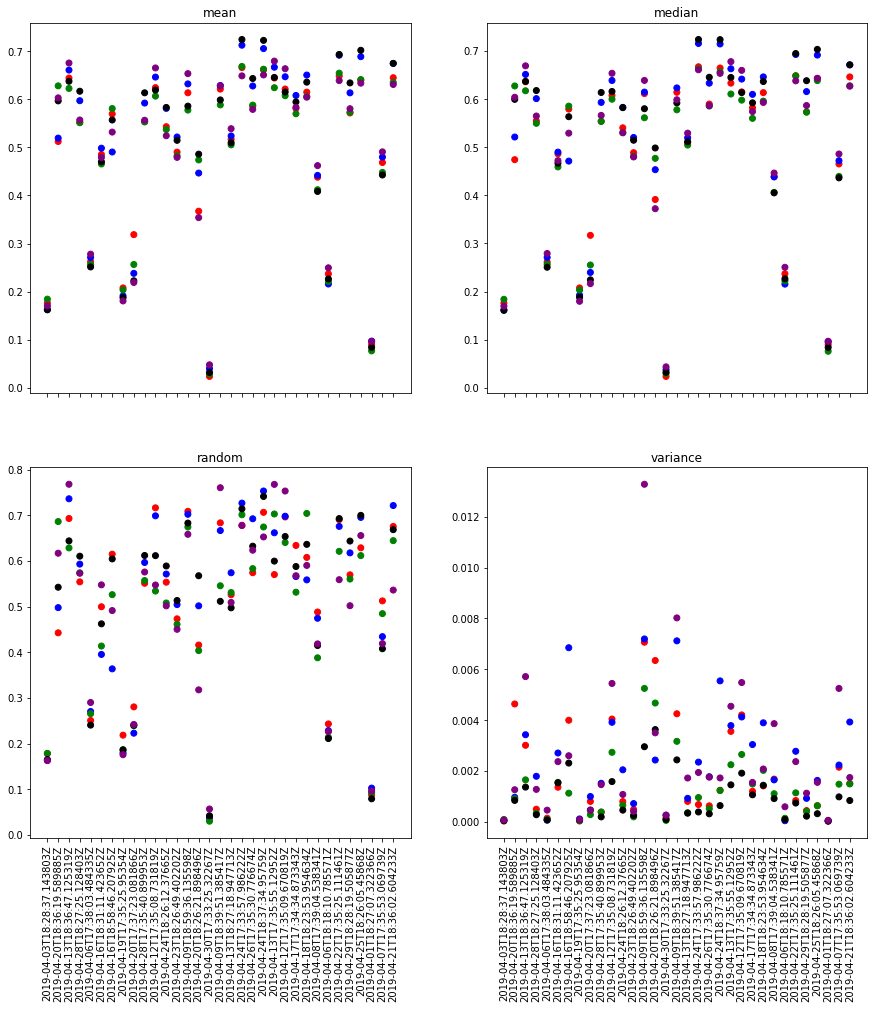

In [115]:
colors = {0:'red', 1:'blue', 2:'green', 3:'black', 4:'purple'}

df = all_stats

stats = ['mean', 'median', 'random', 'variance']
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,15))
# print(dir(axes[0][0]))
for stat, ax in zip(stats, axes.flatten()):
    ax.scatter(df['acquired'], df[stat], c=df['block'].apply(lambda x: colors[x]))
    ax.set_title(stat)
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.show()

Well. We did it! We created a table of summary statistics from test blocks within a field for a time series. If the field blocks had been *actual* test blocks, we would likely see variation between the blocks! But in this demo, the field blocks were drawn randomly by hand. So it is no surprise there isn't much variation. That is actually a good thing!

Now that you know how to convert pixels within an aoi to tabular data, the sky is the limit! 